# Clustering

In [285]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# KMEANS
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer 
from yellowbrick.cluster import silhouette_visualizer 

# DBSCAN
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# HIERARCHICAL
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# EMA - XMEANS - FCM
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.ema import ema, ema_initializer, ema_init_type
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.fcm import fcm

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"

pd.set_option('display.max_columns', None)

In [2]:
# Utiliy functions
interesting_features = ['mean_rank_points', 'lrpOnAvgrp', 'age', 'total_matches_played']

def show_pca_visualization(cluster_type: str):
  df = df_players[df_players.select_dtypes(include = np.number).columns.tolist()].drop(columns = ['ht', 'mean_minutes', 'max_minutes', 'rel_ace', 'rel_df', 'rel_1stIn', 'rel_1stWon', 'rel_2ndWon', '1WonOn1In', '1WonOnTotWon', 'rel_ptsWon', 'rel_bpFaced', 'rel_bpSaved', 'rel_gmsWon'])
  df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
  components_df = pd.DataFrame(PCA(n_components=2).fit_transform(df))
  px.scatter(x=components_df[0], y=components_df[1], color=df_players[cluster_type]).show()

def show_interpretation_table(cluster_type: str):
  return df_players.groupby(cluster_type).agg({cluster_type:"count", "mean_rank_points": "mean", "lrpOnAvgrp": "mean", "age": "mean", "matches_won_ratio": "mean", "total_matches_played": "mean", "performance_index_entropy":"mean"}).sort_values(by="mean_rank_points", ascending=False).round(2).rename(columns={cluster_type: "cluster size"})

## Preparation

In [3]:
df_players = pd.read_csv("./datasets/players.csv", index_col=0)
feautures = ['max_tourney_revenue', 'mean_rank_points', 'lrpOnMxrp', 'matches_won_ratio']

In [4]:
for feature in feautures:
    df_players[feature].hist().show()

### Normalization

In [ ]:
df_data = df_players[feautures].reset_index(drop=True)
df_data = df_data.round(3)

# Transformations
#df_data['mean_rank_points'] = np.log(df_data['mean_rank_points'])

# Plot
df_data['mean_rank_points'].hist().show()
df_data = pd.DataFrame(MinMaxScaler().fit_transform(df_data), columns=df_data.columns)
df_data.boxplot(column=feautures).show()

## K-means

### Find Optimal K

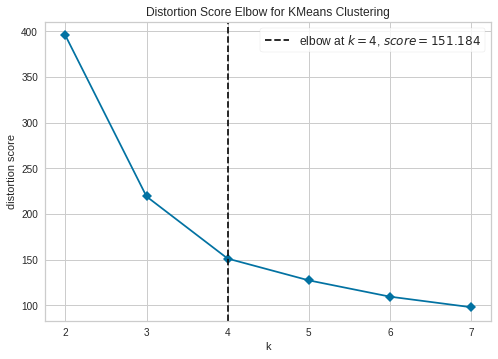

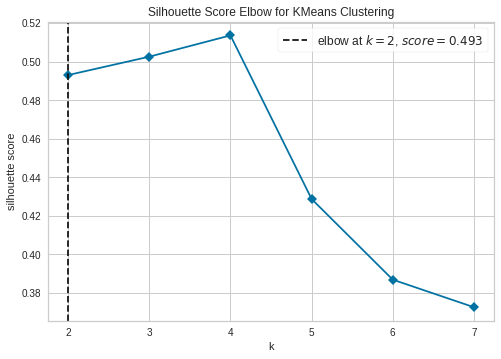

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [6]:
model = KMeans(n_init=10, max_iter=100, init="k-means++")
sse_visualizer = KElbowVisualizer(model, k=(2,8), timings=False)
sse_visualizer.fit(df_data)
sse_visualizer.show()

sil_visualizer = KElbowVisualizer(model, k=(2,8), timings=False, metric="silhouette")
sil_visualizer.fit(df_data)
sil_visualizer.show()

Picking optimal K

The optimal `k` is 4

In [7]:
optimal_k = sse_visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=100, init="k-means++")
kmeans.fit(df_data)

df_players["cluster_kmeans"] = kmeans.labels_.astype(str)

x = silhouette_visualizer(KMeans(optimal_k, random_state=42), df_data)
print("The silhoutte score is: " + str(x.silhouette_score_))

The silhoutte score is: 0.5136207037928655


### Result analysis

In [8]:
show_interpretation_table("cluster_kmeans")

cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_kmeans                                                      
3                        409            628.37        0.59  25.49   
1                        474            561.68        1.87  21.22   
0                        764             53.49        0.59  22.46   
2                       1350             33.80        1.54  19.37   

                matches_won_ratio  total_matches_played  \
cluster_kmeans                                            
3                            0.52                182.23   
1                            0.56                226.69   
0                            0.42                 68.70   
2                            0.46                 75.32   

                performance_index_entropy  
cluster_kmeans                             
3                                    4.68  
1                                    4.96  
0                                    3.45  
2                                    3.56

Plot of the k-means centers

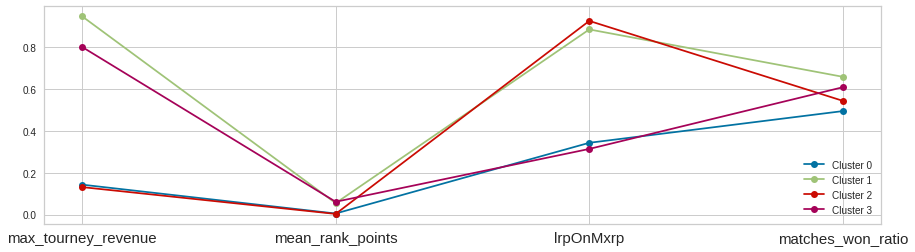

In [9]:
plt.figure(figsize=(15, 4))
for i in range(0, len(kmeans.cluster_centers_)):
    plt.plot(kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(0, len(df_data.columns)), df_data.columns, fontsize=15)
plt.legend(fontsize=10)
plt.show()

#### PCA visualization

In [10]:
show_pca_visualization(cluster_type="cluster_kmeans")

#### Scatter matrix of selected features

In [11]:
px.scatter_matrix(df_players,
    dimensions=feautures,
    color="cluster_kmeans")

#### Scatter matrix of interesting features

In [12]:
px.scatter_matrix(df_players,
    dimensions=interesting_features,
    color="cluster_kmeans")

#### Histograms of interesting features by gender
The only important difference between male and female players that can be seen is that female players tend to be more than the counterpart, nevertheless no discrimination is made

In [13]:
for feature in interesting_features:
  px.histogram(df_players, x=feature, facet_col="cluster_kmeans", color=df_players.gender).show()

Clustering does not clearly distinguish between classes of players, however it is possible to find fairly defined patterns by observing the following histograms (6, 7, 8, 9) and the plot related to the centroids and the plot regarding the centroids (10).

- Cluster 0 represents the young promises: those with low mean rank points, an average low age and on average the ones with the strongest trends of growth (looking at the lrpOnAvgrp).
- Cluster 1 represent the strongest players: with experience and a generally higher age. They have high mean rank points and perform the best in term of matches won ratio.
- Cluster 2 represent good players with a decreasing trend.
- Cluster 3: represents the bad players: with low mean rank points and a decreasing trend.

## Density-based

In [15]:
# pair-wise distance and then compute distance matrix
dist = pdist(X=df_data, metric='euclidean')
dist = squareform(dist)

kmin, kmax = 3, 30
kth_distances = {k:[] for k in range(kmin, kmax + 1)}

for d in dist:
    indexes_to_sort_d = np.argsort(d)
    for k in range(kmin, kmax + 1):
        kth_distances[k].append(d[indexes_to_sort_d[k]])

fig = go.Figure()
for k in kth_distances.keys():
    fig.add_trace(go.Scatter(x = np.array(range(0, len(kth_distances[k]))), y = sorted(kth_distances[k]), mode = 'lines' , name = str(k)))
fig.show()

### Find optimal hyper-parameters

In [16]:
def get_metrics(eps, min_samples, dataset, iter_):
    # Fit the model
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean noise point distance metric
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of clusters metric
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    return(noise_mean_distance, number_of_clusters)

eps_to_test = [round(eps,1) for eps in np.arange(0.1, 3, 0.1)]
min_samples_to_test = range(3, 30, 2)

# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

iter_ = 0
for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        iter_ += 1
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, df_data, iter_)

        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

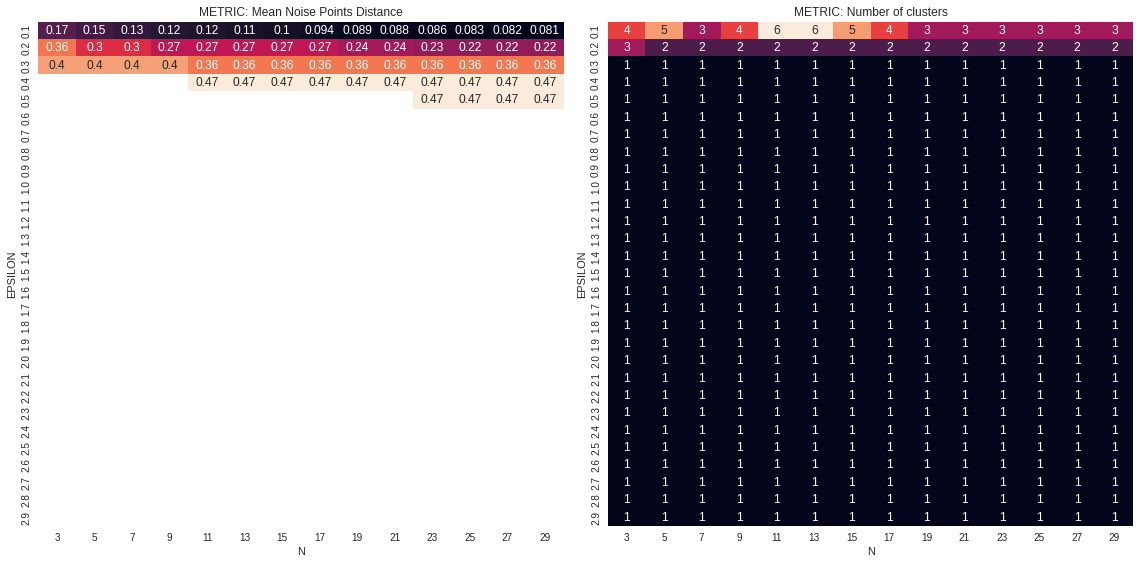

In [17]:
# sm = (results_clusters >= 2) & (results_clusters <= 5)
# sm = (results_clusters == 3)
sm = (results_clusters >=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )
sns.heatmap(results_noise[sm], annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters[sm], annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")
ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")
plt.tight_layout(); plt.show()

In [18]:
# dbscan = DBSCAN(eps=0.9, min_samples=3).fit(df_data)
# dbscan = DBSCAN(eps=0.4, min_samples=29).fit(df_data)
dbscan = DBSCAN(eps=0.15, min_samples=4).fit(df_data)

results = np.unique(dbscan.labels_, return_counts=True)
print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")
df_players["cluster_dbscan"] = dbscan.labels_.astype(str)

Clusters labels: [-1  0  1]
Elements per cluster: [  13 2395  589]


### Result analysis

In [19]:
show_interpretation_table("cluster_dbscan")

cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_dbscan                                                      
-1                        13           4500.80        0.76  28.24   
1                        589            651.49        1.54  22.35   
0                       2395             69.93        1.14  20.99   

                matches_won_ratio  total_matches_played  \
cluster_dbscan                                            
-1                           0.68                191.46   
1                            0.56                237.32   
0                            0.46                 80.96   

                performance_index_entropy  
cluster_dbscan                             
-1                                   4.68  
1                                    5.05  
0                                    3.62

#### PCA visualization

In [20]:
show_pca_visualization(cluster_type="cluster_dbscan")

#### Scatter matrix of selected features

In [21]:
px.scatter_matrix(df_players,
    dimensions=feautures,
    color="cluster_dbscan")

#### Scatter matrix of interesting features

In [22]:
px.scatter_matrix(df_players,
    dimensions=interesting_features,
    color="cluster_dbscan")

In [23]:
px.scatter(df_players, x='mean_rank_points', y='matches_won_ratio', color = 'cluster_dbscan')

#### Interpretation
The clusters result fairly balanced in the number of elements and they represented either good or bad players.
The noise labelled by DBSCAN was none other than very bad o very good player.

## Hierarchical

### Utility functions

In [25]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [26]:
# print some info regarding the clustering and add 'cluster_hierarchical' attribute to dataframe
def info(model, df_players, df_data):
    results = np.unique(model.labels_, return_counts=True)
    print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")

    df_players["cluster_hierarchical"] = model.labels_.astype(str)
    #df_players = df_players[df_players.select_dtypes(include = np.number).columns.tolist()].drop(columns = ['ht', 'mean_minutes', 'max_minutes', 'rel_ace', 'rel_df', 'rel_1stIn', 'rel_1stWon', 'rel_2ndWon', '1WonOn1In', '1WonOnTotWon', 'rel_ptsWon', 'rel_bpFaced', 'rel_bpSaved', 'rel_gmsWon'])
    print("Silhouette score: " + str(silhouette_score(df_data, model.labels_.astype(str))))

### Ward

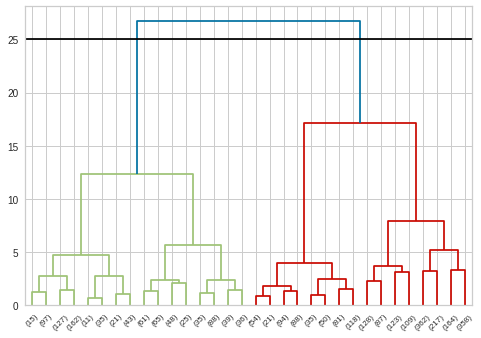

In [27]:
threshold_value = 25

# plot the full dendogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = model.fit(df_data)
plot_dendrogram(model, truncate_mode="level", color_threshold=threshold_value, p=4)
if threshold_value != None:
    plt.axhline(y=threshold_value, color="black")
plt.show()

In [28]:
# run again agglomerating up to 2 clusters
model = AgglomerativeClustering(n_clusters=2, linkage='ward')
model = model.fit(df_data)

#### Results analysis

In [29]:
info(model, df_players, df_data)
show_interpretation_table("cluster_hierarchical")

Clusters labels: [0 1]
Elements per cluster: [2089  908]
Silhouette score: 0.48700294833214414


cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_hierarchical                                                      
1                              908            578.64        1.25  23.22   
0                             2089             40.37        1.21  20.44   

                      matches_won_ratio  total_matches_played  \
cluster_hierarchical                                            
1                                  0.54                201.57   
0                                  0.45                 73.31   

                      performance_index_entropy  
cluster_hierarchical                             
1                                          4.79  
0                                          3.52

In [30]:
px.scatter_matrix(df_players,
    dimensions=interesting_features,
    color="cluster_dbscan")

In [31]:
show_pca_visualization(cluster_type="cluster_hierarchical")

### Complete

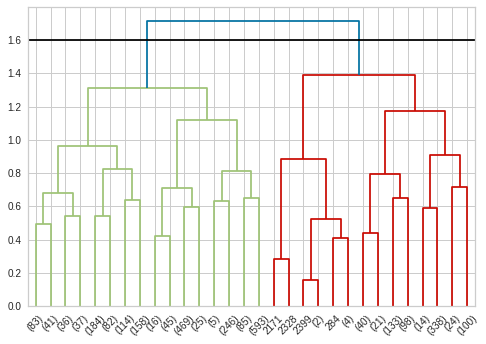

In [32]:
threshold_value = 1.6

# plot the full dendogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
model = model.fit(df_data)
plot_dendrogram(model, truncate_mode="level", color_threshold=threshold_value, p=4)
if threshold_value != None:
    plt.axhline(y=threshold_value, color="black")
plt.show()

In [33]:
# run again agglomerating up to 3 clusters
model = AgglomerativeClustering(n_clusters=4, linkage='complete')
model = model.fit(df_data)

#### Results analysis

In [34]:
info(model, df_players, df_data)
show_interpretation_table("cluster_hierarchical")

Clusters labels: [0 1 2 3]
Elements per cluster: [ 768 1484   10  735]
Silhouette score: 0.44102252364992234


cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_hierarchical                                                      
2                               10           5800.42        0.64  28.62   
0                              768            552.65        1.51  22.35   
3                              735            102.47        0.46  23.30   
1                             1484             35.02        1.45  19.69   

                      matches_won_ratio  total_matches_played  \
cluster_hierarchical                                            
2                                  0.75                246.90   
0                                  0.55                211.72   
3                                  0.42                 77.35   
1                                  0.47                 76.98   

                      performance_index_entropy  
cluster_hierarchical                             
2                                          5.32  
0                                          4.86  
3                                          3.54  
1                                          3.59

### Single

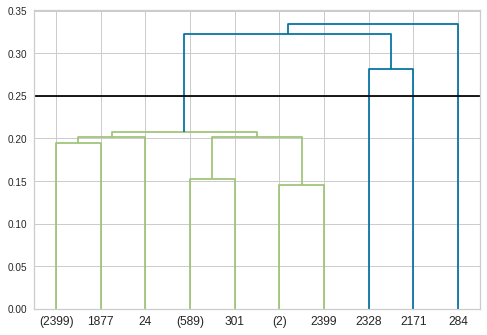

In [35]:
threshold_value = 0.25

# plot the full dendogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')
model = model.fit(df_data)
plot_dendrogram(model, truncate_mode="level", color_threshold=threshold_value, p=4)
if threshold_value != None:
    plt.axhline(y=threshold_value, color="black")
plt.show()

In [36]:
# run again agglomerating up to 4 clusters
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
model = model.fit(df_data)

#### Results analysis

In [37]:
info(model, df_players, df_data)
show_interpretation_table("cluster_hierarchical")

Clusters labels: [0 1 2 3]
Elements per cluster: [1548  397  541  511]
Silhouette score: 0.4760143098334013


cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_hierarchical                                                      
1                              397            676.61        0.55  25.35   
3                              511            502.52        1.78  21.57   
2                              541             51.81        0.47  22.77   
0                             1548             36.37        1.46  19.63   

                      matches_won_ratio  total_matches_played  \
cluster_hierarchical                                            
1                                  0.52                182.94   
3                                  0.55                216.04   
2                                  0.42                 64.89   
0                                  0.46                 76.25   

                      performance_index_entropy  
cluster_hierarchical                             
1                                          4.66  
3                                          4.88  
2                                          3.41  
0                                          3.56

### Average

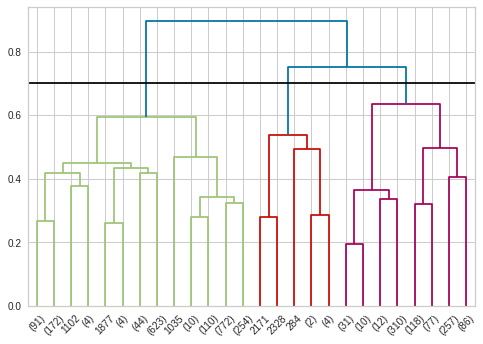

In [38]:
threshold_value = 0.7

# plot the full dendogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
model = model.fit(df_data)
plot_dendrogram(model, truncate_mode="level", color_threshold=threshold_value, p=4)
if threshold_value != None:
    plt.axhline(y=threshold_value, color="black")
plt.show()

In [39]:
# run again agglomerating up to 3 clusters
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
model = model.fit(df_data)

#### Results analysis

In [40]:
info(model, df_players, df_data)
show_interpretation_table("cluster_hierarchical")

Clusters labels: [0 1 2]
Elements per cluster: [ 908 1548  541]
Silhouette score: 0.4607242142846791


cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_hierarchical                                                      
0                              908            578.64        1.25  23.22   
2                              541             51.81        0.47  22.77   
1                             1548             36.37        1.46  19.63   

                      matches_won_ratio  total_matches_played  \
cluster_hierarchical                                            
0                                  0.54                201.57   
2                                  0.42                 64.89   
1                                  0.46                 76.25   

                      performance_index_entropy  
cluster_hierarchical                             
0                                          4.79  
2                                          3.41  
1                                          3.56

## EMA

In [297]:
df = df_data.values.tolist()
amount_clusters=2
initial_means, initial_covariance = ema_initializer(df, amount_clusters).initialize(ema_init_type.KMEANS_INITIALIZATION)
ema_instance = ema(df, 2, initial_means, initial_covariance, tolerance=100)
ema_instance.process()

# Get clustering results.
clusters = ema_instance.get_clusters()
covariances = ema_instance.get_covariances()
means = ema_instance.get_centers()

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)}")

for i, cluster in zip(range(len(clusters)), clusters):
    df_players.loc[df_players.index[cluster], 'cluster_gm'] = str(i)

Cluster 0: 1985
Cluster 1: 1012


In [119]:
show_pca_visualization("cluster_gm")
show_interpretation_table("cluster_gm")

cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_gm                                                      
1                   1012            533.00        1.23  23.28   
0                   1985             35.43        1.21  20.27   

            matches_won_ratio  total_matches_played  performance_index_entropy  
cluster_gm                                                                      
1                        0.53                190.15                       4.68  
0                        0.45                 72.41                       3.51

## X-MEAN

In [259]:
# Create initial centers for xmeans algorithm
amount_initial_centers = 2
maximum_clusters = 40
initial_centers = kmeans_plusplus_initializer(df_data, amount_initial_centers, random_state=42).initialize()
 
# Create instance of X-Means algorithm with Bayesian Information Criterion (BIC) splitting criterion.
xmeans_instance = xmeans(df_data, initial_centers, maximum_clusters, tolerance=0.5, random_state=47)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())

# Add results to dataset
xmeans_clusters = [] 
for i in range(0, len(clusters)):
    for j in clusters[i]:
        xmeans_clusters.append((j, i))

# sort according to first element of tuple
xmeans_clusters.sort(key=lambda tup: tup[0])
# keep only second element of tuple
xmeans_clusters = np.array([tup[1] for tup in xmeans_clusters])

df_players["cluster_xmeans"] = xmeans_clusters.astype(str)
print("clusters found: " + str(len(clusters)) + " on a maximum of " + str(maximum_clusters))

Total WCE: 505.31994306302647
clusters found: 2 on a maximum of 40


### Results analysis

In [260]:
show_pca_visualization("cluster_xmeans")
show_interpretation_table("cluster_xmeans")

cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_xmeans                                                      
1                       1189            399.37        0.75  23.69   
0                       1808             74.60        1.53  19.70   

                matches_won_ratio  total_matches_played  \
cluster_xmeans                                            
1                            0.49                147.98   
0                            0.47                 88.61   

                performance_index_entropy  
cluster_xmeans                             
1                                    4.26  
0                                    3.68

### Result analysis

In [272]:
plt.figure(figsize=(15, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(0, len(df_data.columns)), df_data.columns, fontsize=15)
plt.legend(fontsize=10)
plt.show()

In [49]:
px.scatter_matrix(df_players,
    dimensions=feautures,
    color="cluster_kmeans")

## Fuzzy C-means

In [216]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 4
initial_centers = kmeans_plusplus_initializer(df_data, amount_initial_centers, random_state=42).initialize()

# Create instance of Fuzzy C-Means algorithm, run it and get results
fcm_instance = fcm(df_data.to_numpy(), initial_centers, m=1.5)
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

# Add cluster label to original dataframe
fcm_clusters = [] 
for i in range(0, len(clusters)):
    for j in clusters[i]:
        fcm_clusters.append((j, i))

# sort according to first element of tuple
fcm_clusters.sort(key=lambda tup: tup[0])
# keep only second element of tuple
fcm_clusters = np.array([tup[1] for tup in fcm_clusters])

df_players["cluster_fcm"] = fcm_clusters.astype(str)
show_interpretation_table("cluster_fcm")

cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_fcm                                                      
1                     407            629.82        0.58  25.50   
2                     476            560.72        1.87  21.23   
3                     763             53.52        0.59  22.46   
0                    1351             33.79        1.54  19.37   

             matches_won_ratio  total_matches_played  \
cluster_fcm                                            
1                         0.52                182.63   
2                         0.56                226.16   
3                         0.42                 68.69   
0                         0.46                 75.33   

             performance_index_entropy  
cluster_fcm                             
1                                 4.68  
2                                 4.96  
3                                 3.45  
0                                 3.56

The fuzzy c-means returns the same results from the k-means and that was expeceted given the fact that the real difference is not in the `fcm_instance.get_clusters()` method but in `fcm_instance.get_membership()` that takes in account the fuzzyness